# Load Forecasting
### 1. Data manipulation

Start by merging the load data and covariate data

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

In [18]:
# Set base directory and load data paths
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')

# Read processed load data and convert 'Time (UTC)' to datetime
load_data = pd.read_csv(load_file_path)

# Rename columns and add new data from other sources
load_data.rename(columns={
    "Actual Total Load [MW] - BZN|SE4": "Actual Load",
    "Time (UTC)": "Time"
}, inplace=True)

load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')

# Set 'Time (UTC)' as index and drop unnecessary column
load_data.set_index('Time', inplace=True)
load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)

# Read other data and add to the dataframe
avg_temperature_data = pd.read_csv(temperature_file_path)
avg_humidity_data = pd.read_csv(humidity_file_path)
avg_solar_data = pd.read_csv(solar_file_path)

# Assign the final DataFrame to `data`
data = load_data.copy()
data['Temperature'] = avg_temperature_data['weighted_avg'].values
data['Humidity'] = avg_humidity_data['weighted_avg'].values
data['Solar'] = avg_solar_data['weighted_avg'].values

# Print the final dataframe
print(data)


                     Actual Load  Temperature   Humidity  Solar
Time                                                           
2015-01-01 00:00:00       2267.0     4.451320  86.611602    0.0
2015-01-01 01:00:00       2281.0     4.217264  85.613668    0.0
2015-01-01 02:00:00       2313.0     4.302403  85.022984    0.0
2015-01-01 03:00:00       2372.0     4.207889  86.857752    0.0
2015-01-01 04:00:00       2424.0     4.572334  85.142699    0.0
...                          ...          ...        ...    ...
2024-12-31 19:00:00       2414.0     5.179142  93.402829    0.0
2024-12-31 20:00:00       2313.0     5.054718  93.775552    0.0
2024-12-31 21:00:00       2231.0     5.103017  92.447421    0.0
2024-12-31 22:00:00       2219.0     5.038400  92.905958    0.0
2024-12-31 23:00:00       2168.0     5.170554  93.280124    0.0

[87672 rows x 4 columns]


In this section we implement the machine learning models. We start with our benchmark model which will later be used to compare the reaults of our 'advanced' models.

MAPE: 8.71%


<Axes: xlabel='Time'>

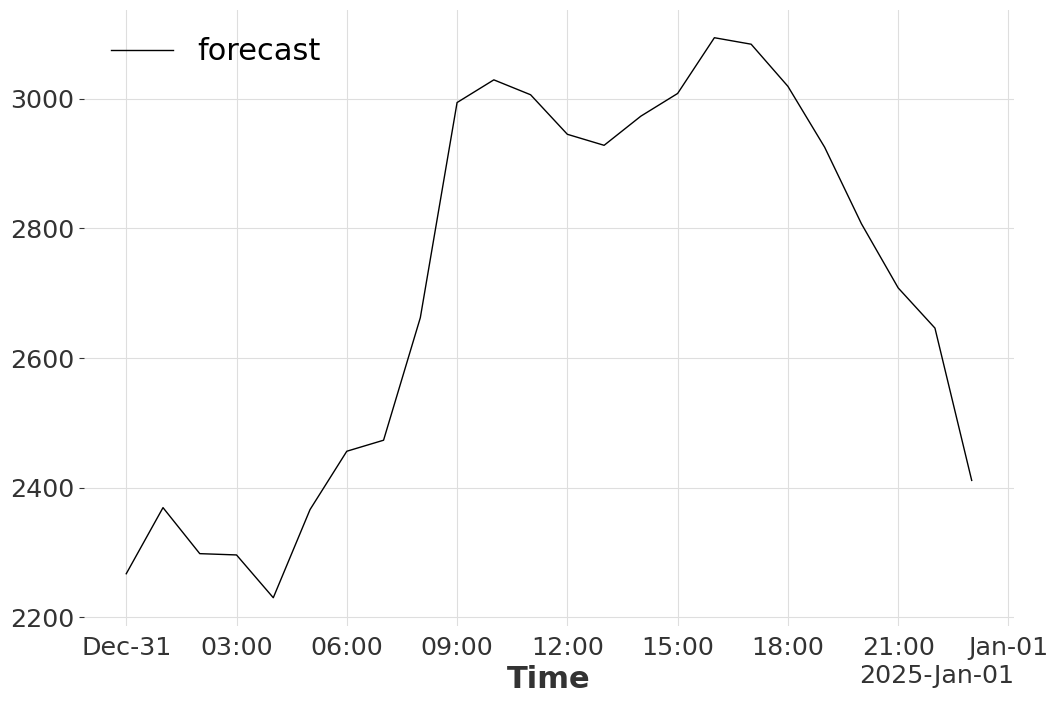

In [19]:
from darts.models import NaiveSeasonal
from darts import TimeSeries
from darts.metrics import mape

# Select one target column only (univariate series)
forecast_data = data['Actual Load']

# Create TimeSeries object
series = TimeSeries.from_series(forecast_data)

# Train/test split for one week forecast
train, actual = series[:-24], series[-24:]

model = NaiveSeasonal(K=24) # weekly seasonality
model.fit(train)
forecast = model.predict(24) # change this to number of hours to be plotted
#print(forecast.pd_dataframe())
# Compute MAPE
error = mape(actual, forecast)
print(f"MAPE: {error:.2f}%")

#plot
forecast.plot(label="forecast", lw=1)

Including holidays as covariate

In [11]:
import holidays

years = np.arange(2015, 2025)

raw_holidays = []
for date, name in sorted(holidays.Sweden(years=years).items()):
    if not name == "Söndag":
        raw_holidays.append(date)
        #print(date, name)
holiday_dates = set(raw_holidays)
print(holiday_dates)

{datetime.date(2022, 4, 17), datetime.date(2016, 1, 6), datetime.date(2016, 11, 5), datetime.date(2018, 5, 20), datetime.date(2023, 5, 18), datetime.date(2020, 12, 26), datetime.date(2020, 5, 31), datetime.date(2021, 5, 23), datetime.date(2018, 11, 3), datetime.date(2018, 6, 22), datetime.date(2024, 6, 22), datetime.date(2021, 12, 25), datetime.date(2017, 12, 26), datetime.date(2024, 11, 2), datetime.date(2021, 6, 26), datetime.date(2019, 6, 21), datetime.date(2015, 4, 5), datetime.date(2023, 6, 23), datetime.date(2023, 12, 24), datetime.date(2021, 4, 2), datetime.date(2016, 3, 25), datetime.date(2015, 10, 31), datetime.date(2021, 11, 6), datetime.date(2016, 12, 25), datetime.date(2022, 1, 1), datetime.date(2016, 3, 28), datetime.date(2021, 5, 13), datetime.date(2022, 4, 18), datetime.date(2017, 4, 16), datetime.date(2023, 4, 9), datetime.date(2021, 6, 25), datetime.date(2019, 11, 2), datetime.date(2023, 1, 1), datetime.date(2017, 5, 1), datetime.date(2016, 1, 1), datetime.date(2024, 3

Now merge all load and covariate data into one data frame

In [21]:

data['is_holiday'] = pd.Series(data.index.date).isin(holiday_dates).astype(int).values
print(data.head())

                     Actual Load  Temperature   Humidity  Solar  is_holiday
Time                                                                       
2015-01-01 00:00:00       2267.0     4.451320  86.611602    0.0           1
2015-01-01 01:00:00       2281.0     4.217264  85.613668    0.0           1
2015-01-01 02:00:00       2313.0     4.302403  85.022984    0.0           1
2015-01-01 03:00:00       2372.0     4.207889  86.857752    0.0           1
2015-01-01 04:00:00       2424.0     4.572334  85.142699    0.0           1


Starting with Gradient Boost Regressor 

In [22]:
# XGBoost Load Forecasting Notebook
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import time

# replace special characters so that XGBoost can handle column names
#data.columns = data.columns.str.replace(r"[\[\]<>]", "", regex=True)

# Feature Engineering
# Example lag and rolling features
# Initialize lag columns with NaN
data['lag_hour'] = np.nan
data['lag_day'] = np.nan
data['lag_week'] = np.nan

# Overwrite the values starting after the first week (1 hour for lag_hour, 24 hours for lag_day, 168 hours for lag_week)
data.loc[data.index[1:], 'lag_hour'] = data['Actual Load'].shift(1).iloc[1:]
data.loc[data.index[24:], 'lag_day'] = data['Actual Load'].shift(24).iloc[24:]
data.loc[data.index[168:], 'lag_week'] = data['Actual Load'].shift(168).iloc[168:]

# Datetime features

data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int)
data.to_csv('data.csv')
#data.dropna(inplace=True)
#print(data.isnull().values.any())
# Target variable (next-day forecast example)
data['target'] = data['Actual Load'].shift(-24)

# Drop rows with NaNs from lagging/rolling
data.dropna(inplace=True)
print(data.tail())
print(len(data))

                     Actual Load  Temperature   Humidity  Solar  is_holiday  \
Time                                                                          
2024-12-30 19:00:00       2925.0     5.350586  94.401386    0.0           0   
2024-12-30 20:00:00       2807.0     5.249733  94.717188    0.0           0   
2024-12-30 21:00:00       2708.0     5.327976  93.895371    0.0           0   
2024-12-30 22:00:00       2646.0     5.443001  93.942850    0.0           0   
2024-12-30 23:00:00       2411.0     5.526796  93.689842    0.0           0   

                     lag_hour  lag_day  lag_week  hour  dayofweek  is_weekend  \
Time                                                                            
2024-12-30 19:00:00    3019.0   2577.0    2736.0    19          0           0   
2024-12-30 20:00:00    2925.0   2478.0    2629.0    20          0           0   
2024-12-30 21:00:00    2807.0   2376.0    2590.0    21          0           0   
2024-12-30 22:00:00    2708.0   2323.0   

Now split data into training, validation and test sets and run the algorithm

In [26]:
# Time-based train/test split
split_dates = ['2022-01-01','2023-01-01','2024-01-01']
train = pd.concat([
    data[split_dates[0]:split_dates[2]],              # from start to 2018-01-01
    #data[split_dates[2]:split_dates[3]] # from 2020-01-01 to 2022-01-01
])
#valid = pd.concat([
#    data[split_dates[1]:split_dates[2]],# from 2018-01-01 to 2019-01-01
    #data[split_dates[3]:split_dates[4]] # from 2022-01-01 to 2023-01-01
#])
test = pd.concat([
    data[split_dates[2]:],# from 2019-01-01 to 2020-01-01
    #data[split_dates[4]:]               # from 2023-01-01 to end
])
print(test.head())

                     Actual Load  Temperature   Humidity  Solar  is_holiday  \
Time                                                                          
2024-01-01 00:00:00       2266.0     3.955766  94.528512    0.0           1   
2024-01-01 01:00:00       2302.0     3.981655  95.433257    0.0           1   
2024-01-01 02:00:00       2225.0     4.001119  94.877398    0.0           1   
2024-01-01 03:00:00       2192.0     3.959614  94.765682    0.0           1   
2024-01-01 04:00:00       2195.0     3.881668  94.860937    0.0           1   

                     lag_hour  lag_day  lag_week  hour  dayofweek  is_weekend  \
Time                                                                            
2024-01-01 00:00:00    2342.0   2305.0    2254.0     0          0           0   
2024-01-01 01:00:00    2266.0   2283.0    2250.0     1          0           0   
2024-01-01 02:00:00    2302.0   2278.0    2242.0     2          0           0   
2024-01-01 03:00:00    2225.0   2252.0   

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=250, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=250, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=250, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=150, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=150, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=150, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END co

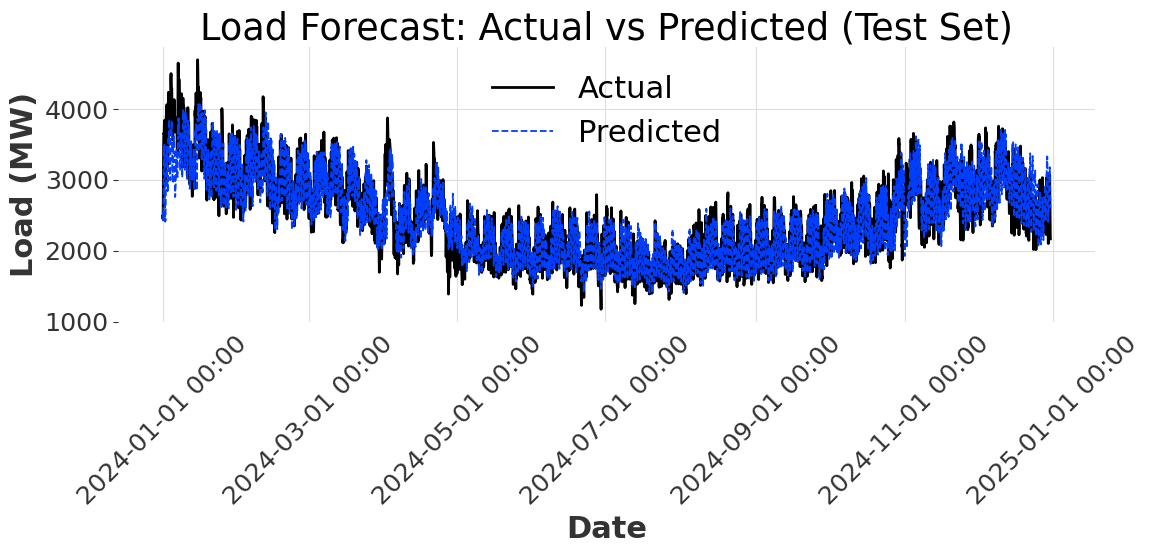

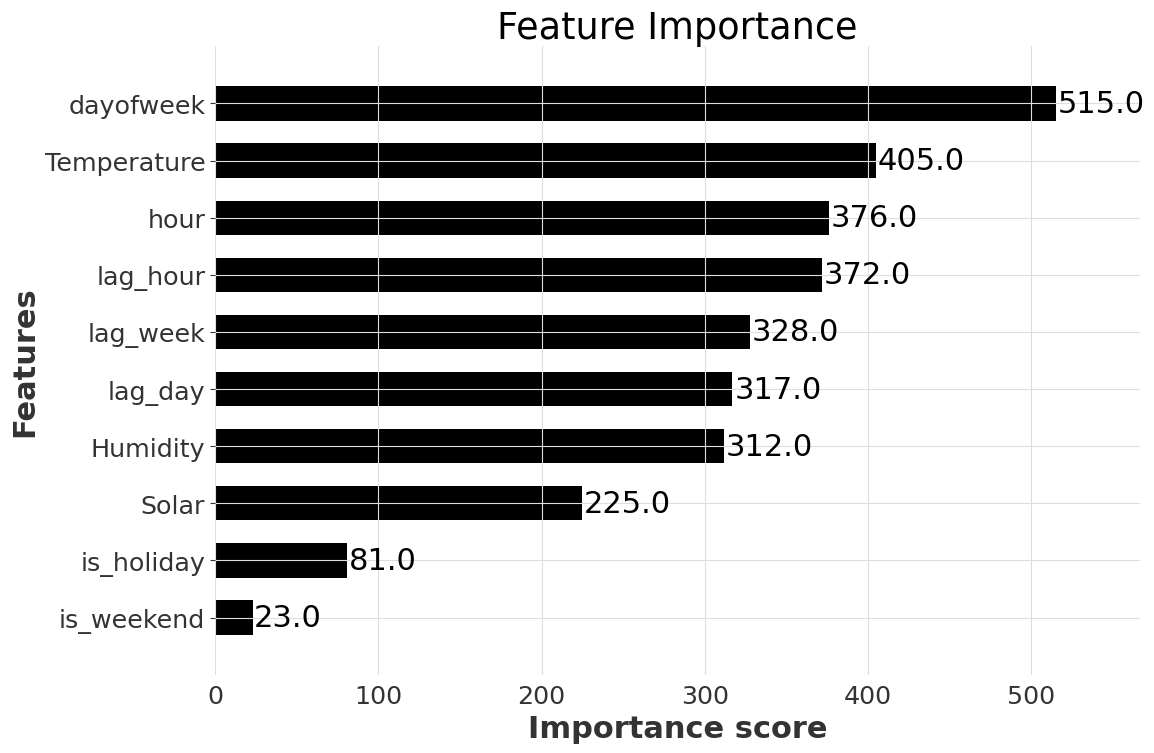

In [27]:
from darts.models import XGBModel
import matplotlib.dates as mdates

# Feature/target split
features = [col for col in data.columns if col not in ['Actual Load', 'target']]
X_train, y_train = train[features], train['target']
#X_valid, y_valid = valid[features], valid['target']
X_test, y_test = test[features], test['target']

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

# Model and search setup
base_model = xgb.XGBModel(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

# Using grid search
#search = GridSearchCV(
#    estimator=base_model,
#    param_grid=param_dist,  
#    scoring='neg_root_mean_squared_error',
#    cv=3,
#    verbose=2,
#    n_jobs=1
#)

# Run search
start = time.time()
search.fit(X_train, y_train)
print("Search took", round((time.time() - start)/60, 2), "minutes")

# Evaluate best model
best_model = search.best_estimator_
print("Best params:", search.best_params_)

# On validation set
#y_pred_valid = best_model.predict(X_valid)
#rmse_valid = root_mean_squared_error(y_valid, y_pred_valid)
#print("Validation RMSE:", rmse_valid)

# refit the best model on full training data (X_train + X_valid)
#best_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# on test set
y_pred_test = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)

mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

# Plot Actual vs Predicted on Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred_test, label='Predicted', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.legend()
plt.title('Load Forecast: Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance Plot
xgb.plot_importance(best_model, height=0.6, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()